## Deep learning models with `PyTorch`

`otbench` provides support for deep learning models implemented in `PyTorch`.

Similar to the other machine learning and statistical models highlighted in the [forecasting overview notebook](/notebooks/forecasting/usna_cn2_sm.ipynb) and the [regression overview notebook](/notebooks/regression/mlo_cn2.ipynb), `otbench` provides `BasePyTorchForecastingModel` and `BasePyTorchRegressionModel` classes that can be extended to implement custom deep learning models.

In this notebook, we will develop a basic recurrent neural network (RNN) for predicting $C_n^2$ at a height above ground of $15 [m]$ using the  MLO $C_n^2$ dataset, described [here](/otb/data/mlo_cn2/README.md).

This notebook serves both to highlight the `BasePyTorchRegressionModel` and to offer an example of implementation for a benchmark deep learning model.

We begin with the usual imports.

In [1]:
import pprint

from otbench.tasks import TaskApi
from otbench.plot import plot_predictions

In [2]:
pprinter = pprint.PrettyPrinter(indent=2, width=100, compact=True)

### Define the `BasePyTorchRegressionModel`

`otbench` provides a `BasePyTorchRegressionModel` class that can be extended to implement custom deep learning models.

For convenience, we reproduce the implementation of `BasePyTorchRegressionModel` below.

In [3]:
import sys
from typing import Tuple, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from otbench.benchmark.models.regression.base_model import BaseRegressionModel

In [4]:
class BasePyTorchRegressionModel(BaseRegressionModel):
    """A the base class for PyTorch models."""

    def __init__(
        self,
        name: str,
        target_name: str,
        window_size: int = 1,  # default to single row
        batch_size: int = 32,
        n_epochs: int = 500,
        learning_rate: float = 0.025,
        criterion: 'torch.nn.modules.loss' = nn.MSELoss(),
        optimizer: 'torch.optim' = optim.SGD,
        random_state: int = 2020,
        verbose: bool = False,
    ):
        super().__init__(name=name, target_name=target_name)
        self.window_size = window_size
        self.batch_size = batch_size
        self.random_state = random_state
        self.n_epochs = n_epochs
        self.criterion = criterion
        self._optimizer_callable = optimizer  # persist callable for later use
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.normalize_data = False
        self.optimizer = None
        self.train_dataloader = None
        self.test_dataloader = None
        self.val_dataloader = None

    def set_model(self,
                  model: 'torch.nn.Module',
                  normalize_data: bool = False,
                  set_optimizer_callable_params: bool = False) -> None:
        """Pass model architecture before training, optionally set optimizer params using model params."""
        self.model = model
        if self.verbose:
            print(f"model: {model}.")
        self.normalize_data = normalize_data
        if self.verbose:
            if self.normalize_data:
                print("will normalize data before training")
            else:
                print("will not normalize data before training.")
        if set_optimizer_callable_params:
            self.optimizer = self._optimizer_callable(self.model.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = self._optimizer_callable(lr=self.learning_rate)

    def set_training_data(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray]) -> None:
        """Pass training data to set model's DataLoader."""
        self._set_dataloader_from_data(X=X, y=y, mode="train")

    def set_test_data(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray, None] = None) -> None:
        """Pass training data to set model's DataLoader."""
        self._set_dataloader_from_data(X=X, y=y, mode="test")

    def set_validation_data(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray, None] = None) -> None:
        """Pass training data to set model's DataLoader."""
        self._set_dataloader_from_data(X=X, y=y, mode="val")

    def train(self, X: Union[pd.DataFrame, np.ndarray], y: Union[pd.DataFrame, np.ndarray]):
        # maintain the same interface as the other models
        raise NotImplementedError

    def predict(self, X: Union[pd.DataFrame, np.ndarray]):
        # maintain the same interface as the other models
        raise NotImplementedError

    def _set_dataloader_from_data(self,
                                  X: Union[pd.DataFrame, np.ndarray],
                                  y: Union[pd.DataFrame, np.ndarray],
                                  mode: str = "val") -> None:
        """Use the data supplied to create train or validation DataLoaders."""
        if y is None and isinstance(X, pd.DataFrame):
            y = X.iloc[:, [0]]
        elif y is None and isinstance(X, np.ndarray):
            y = X[:, [0]]
        elif y is None:
            raise ValueError("y must be supplied if X is not a pd.DataFrame  or np.ndarray object.")

        if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame):
            # reshape to apply window size
            n_features = len(X.columns) // self.window_size
            X = X.to_numpy()
            y = y.to_numpy()
            X = X.reshape(-1, self.window_size, n_features)

            if self.normalize_data:
                if mode == "train":
                    X, y = self._normalize_data(X=X, y=y)
                else:
                    X, y = self._apply_normalization(X=X, y=y)
        else:
            if not isinstance(X, np.ndarray) and isinstance(y, np.ndarray):
                raise ValueError("X and y must be both be pd.DataFrame objects or np.ndarray objects.")
        X, y = self._map_to_tensor(X, y)
        if mode == "train":
            dataloader = self._create_dataloader(X=X, y=y, batch_size=self.batch_size, shuffle=True)
            self.train_dataloader = dataloader
        elif mode == "test":
            dataloader = self._create_dataloader(X=X, y=y, batch_size=self.batch_size, shuffle=True)
            self.test_dataloader = dataloader
        else:
            dataloader = self._create_dataloader(X=X, y=y, batch_size=1, shuffle=False)
            self.val_dataloader = dataloader

    def _normalize_data(self, X: 'pd.DataFrame', y: 'pd.DataFrame') -> Tuple[np.ndarray, np.ndarray]:
        """Normalize the data before training."""
        # normalize the training data
        X_mean = np.nanmean(X, axis=(0, 1))
        X_std = np.nanstd(X, axis=(0, 1)) + sys.float_info.epsilon
        y_mean = np.nanmean(y, axis=(0, 1))
        y_std = np.nanstd(y, axis=(0, 1)) + sys.float_info.epsilon

        # save the mean and std
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std

        return self._apply_normalization(X, y)

    def _apply_normalization(self, X: Union['pd.DataFrame', np.ndarray],
                             y: Union['pd.DataFrame', np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        """Apply normalization learned during training for test or validation."""
        # replace missing values with the mean of that column
        X[np.isnan(X)] = np.take(self.X_mean, np.where(np.isnan(X))[1])
        y[np.isnan(y)] = np.take(self.y_mean, np.where(np.isnan(y))[1])

        # normalize the data before training
        X = (X - self.X_mean) / self.X_std
        y = (y - self.y_mean) / self.y_std

        return X, y

    def _map_to_tensor(self, X: 'np.ndarray', y: 'np.ndarray') -> Tuple['torch.Tensor', 'torch.Tensor']:
        """Convert the data to torch tensors."""
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)

        return X, y

    def _create_dataloader(self,
                           X: 'torch.Tensor',
                           y: 'torch.Tensor',
                           batch_size: int = 1,
                           shuffle: bool = True) -> 'torch.utils.data.TensorDataset':
        """Create the dataset and dataloader."""
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

        if self.verbose:
            print(f"dataloader created with length {len(dataloader)}.")

        return dataloader


Before implementing our custom model, we will first investigate the `BasePyTorchRegressionModel` class in more detail.

#### the `__init__` method

The `__init__` method of `BasePyTorchRegressionModel` serves primarily to persist the model's hyperparameters.

```python
    def __init__(
        self,
        name: str,
        target_name: str,
        window_size: int = 1,  # default to single row
        batch_size: int = 32,
        n_epochs: int = 500,
        learning_rate: float = 0.025,
        criterion: 'torch.nn.modules.loss' = nn.MSELoss(),
        optimizer: 'torch.optim' = optim.SGD,
        random_state: int = 2020,
        verbose: bool = False,
    ):
        super().__init__(name=name, target_name=target_name)
        self.window_size = window_size
        self.batch_size = batch_size
        self.random_state = random_state
        self.n_epochs = n_epochs
        self.criterion = criterion
        self._optimizer_callable = optimizer  # persist callable for later use
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.normalize_data = False
        self.optimizer = None
        self.train_dataloader = None
        self.test_dataloader = None
        self.val_dataloader = None
```

As we inherit from the `BaseRegressionModel` class, we must provide a `name` and `target_name` for our model.

We define a default a default `critierion` of `nn.MSELoss()` and `optimizer` of `optim.SGD`. These can be overridden by the user. Note that the `optimizer` is persisted as a callable for later use, in cases where the model's architecture informs the optimizer.

We also define standard hyperparameters for the model, including `window_size`, `batch_size`, `n_epochs`, `learning_rate`, and `random_state`.

Finally, we define a `verbose` flag that can be used to control the verbosity of the model's development and training.

There are three methods that must be implemented by the user; `__init__`, `train`, and `predict`.

#### the `set_model` method

The `set_model` method takes a `torch.nn.Module` object and persists it as the model's `model` attribute. It also allows the user to specify whether or not to normalize the data before training, and whether or not to set the optimizer's parameters using the model's parameters.

```python
def set_model(self,
                model: 'torch.nn.Module',
                normalize_data: bool = False,
                set_optimizer_callable_params: bool = False) -> None:
    """Pass model architecture before training, optionally set optimizer params using model params."""
    self.model = model
    if self.verbose:
        print(f"model: {model}.")
    self.normalize_data = normalize_data
    if self.verbose:
        if self.normalize_data:
            print("will normalize data before training")
        else:
            print("will not normalize data before training.")
    if set_optimizer_callable_params:
        self.optimizer = self._optimizer_callable(self.model.parameters(), lr=self.learning_rate)
    else:
        self.optimizer = self._optimizer_callable(lr=self.learning_rate)
```

#### the `set_..._data` methods

The `set_train_data`, `set_test_data`, and `set_validation_data` methods are used to set the training, testing, and validation data for the model. Each takes as input `X` and `y` either as `pd.DataFrame` objects or as `np.ndarray` objects. These need not be manually normalized.

Internally, the corresponding `torch.utils.data.DataLoader` object is created and set, normalizing the data if needed.

#### the `_set_dataloader_from_data` method

Each of the `set_..._data` methods apply normalization if needed, and then create a `torch.utils.data.DataLoader` object from the supplied data. The `_set_dataloader_from_data` method is used to create the `torch.utils.data.DataLoader` object.

```python
def _set_dataloader_from_data(self,
                              X: Union[pd.DataFrame, np.ndarray],
                              y: Union[pd.DataFrame, np.ndarray],
                              mode: str = "val") -> None:
    """Use the data supplied to create train or validation DataLoaders."""
    if y is None and isinstance(X, pd.DataFrame):
            y = X.iloc[:, [0]]
        elif y is None and isinstance(X, np.ndarray):
            y = X[:, [0]]
        elif y is None:
            raise ValueError("y must be supplied if X is not a pd.DataFrame  or np.ndarray object.")

    if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame):
        # reshape to apply window size
        n_features = len(X.columns) // self.window_size
        X = X.to_numpy()
        y = y.to_numpy()
        X = X.reshape(-1, self.window_size, n_features)

        if self.normalize_data:
            if mode == "train":
                X, y = self._normalize_data(X=X, y=y)
            else:
                X, y = self._apply_normalization(X=X, y=y)
    else:
        if not isinstance(X, np.ndarray) and isinstance(y, np.ndarray):
            raise ValueError("X and y must be both be pd.DataFrame objects or np.ndarray objects.")
    X, y = self._map_to_tensor(X, y)
    if mode == "train":
        dataloader = self._create_dataloader(X=X, y=y, batch_size=self.batch_size, shuffle=True)
        self.train_dataloader = dataloader
    elif mode == "test":
        dataloader = self._create_dataloader(X=X, y=y, batch_size=self.batch_size, shuffle=True)
        self.test_dataloader = dataloader
    else:
        dataloader = self._create_dataloader(X=X, y=y, batch_size=1, shuffle=False)
        self.val_dataloader = dataloader
```

The `mode` parameter is used to determine whether the `DataLoader` object is for training, testing, or validation. The `batch_size` is set to `1` for validation, and `shuffle` is set to `True` for training and testing.

Each dataloader will return a tuple of `(X, y)` values, where `X` is a `torch.Tensor` object of shape `(batch_size, window_size, n_features)` and `y` is a `torch.Tensor` object of shape `(batch_size, 1)`.

### Implement a custom RNN model using `BasePyTorchRegressionModel`

The `BasePyTorchRegressionModel` class provides a convenient framework for implementing custom deep learning models. It does not, however, provide any model specific model architecture.

We can implement a basic RNN model by first defining the underlying model architecture, and then extending the `BasePyTorchRegressionModel` class to implement the `train` and `predict` methods.

#### Define the underlying model architecture

Our RNN model will consist of a single `torch.nn.RNN` layer, followed by a `torch.nn.Linear` layer. We will use the default `torch.nn.Tanh` activation function for the `torch.nn.RNN` layer, and no activation function for the `torch.nn.Linear` layer.

Additionally, we will not specifically define a fixed `input_size` or `hidden_size` for the `torch.nn.RNN` layer. Instead, we will allow the user to specify these values when instantiating the model.

In [5]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if input_size <= 0:
            raise AssertionError("input size must be greater than 0")

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, _ = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

#### Create a custom `PyTorchRNNModel` class

With our architecture defined, we can now extend the `BasePyTorchRegressionModel` class to implement our custom RNN model.

We will need to provide concrete implementations of the `__init__`, `train`, and `predict` methods.

In [6]:
class RNNModel(BasePyTorchRegressionModel):
    """A basic PyTorch RNN model."""

    def __init__(
            self,
            name: str,
            target_name: str,
            input_size: int,
            window_size: int = 1,  # default to single row
            hidden_size: int = 512,
            num_layers: int = 2,
            num_classes: int = 1,
            batch_size: int = 32,
            n_epochs: int = 500,
            learning_rate: float = 0.025,
            criterion: 'torch.nn.modules.loss' = nn.MSELoss(),
            optimizer: 'torch.optim' = optim.SGD,
            normalize_data: bool = True,
            random_state: int = 2020,
            verbose: bool = False,
            **kwargs):
        super().__init__(name=name,
                         target_name=target_name,
                         window_size=window_size,
                         batch_size=batch_size,
                         n_epochs=n_epochs,
                         learning_rate=learning_rate,
                         criterion=criterion,
                         optimizer=optimizer,
                         random_state=random_state,
                         verbose=verbose)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # create and set the model
        model = RNN(input_size, hidden_size, num_layers, num_classes)
        self.set_model(model=model, normalize_data=normalize_data,
                       set_optimizer_callable_params=True)  # apply model params to SGD

    def train(self, X: 'pd.DataFrame', y: 'pd.DataFrame'):
        # maintain the same interface as the other models
        n_features = len(X.columns) // self.window_size
        if self.verbose:
            print(f"training data contains {n_features} features.")
        # set train dataloader
        self.set_training_data(X=X, y=y)
        # train the model
        torch.manual_seed(self.random_state)
        for i in range(self.n_epochs):
            for _, (X, y) in enumerate(self.train_dataloader):
                self.optimizer.zero_grad()
                outputs = self.model(X.float())
                loss = self.criterion(outputs, y.float())
                loss.backward()
                self.optimizer.step()
            if self.verbose and self.n_epochs >= 10 and (i % (self.n_epochs // 10) == 0):
                print(f"at epoch {i}. loss: {loss}")

    def predict(self, X: 'pd.DataFrame'):
        """Generate predictions from the RNNModel."""
        n_features = len(X.columns) // self.window_size
        if self.verbose:
            print(f"validation data contains {n_features} features.")
        y = X.iloc[:, [0]]
        self.set_validation_data(X=X, y=y)

        pred = []
        with torch.no_grad():
            for _, (X, _) in enumerate(self.val_dataloader):
                y_pred = self.model(X.float())
                if self.normalize_data:
                    y_pred = y_pred * self.y_std + self.y_mean
                y_pred = y_pred.numpy()

                # add the prediction value to the list
                pred.append(y_pred[0][0])

        return np.array(pred)


##### The `__init__` method

Our `__init__` method will accept the `input_size` and `hidden_size` parameters, and pass them to the `torch.nn.RNN` layer.

We also have an opportunity to override the default `optimizer` and `criterion` parameters if desired for our specific model architecture.

```python
class RNNModel(BasePyTorchRegressionModel):
    """A basic PyTorch RNN model."""

    def __init__(
            self,
            name: str,
            target_name: str,
            input_size: int,
            window_size: int = 1,  # default to single row
            hidden_size: int = 512,
            num_layers: int = 2,
            num_classes: int = 1,
            batch_size: int = 32,
            n_epochs: int = 500,
            learning_rate: float = 0.025,
            criterion: 'torch.nn.modules.loss' = nn.MSELoss(),
            optimizer: 'torch.optim' = optim.SGD,
            normalize_data: bool = True,
            random_state: int = 2020,
            verbose: bool = False,
            **kwargs):
        super().__init__(name=name,
                         target_name=target_name,
                         window_size=window_size,
                         batch_size=batch_size,
                         n_epochs=n_epochs,
                         learning_rate=learning_rate,
                         criterion=criterion,
                         optimizer=optimizer,
                         random_state=random_state,
                         verbose=verbose)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # create and set the model
        model = RNN(input_size, hidden_size, num_layers, num_classes)
        self.set_model(model=model, normalize_data=normalize_data,
                       set_optimizer_callable_params=True)  # apply model params to SGD
```

##### The `train` method

The `train` method defines how we use the `X` and `y` data for our modeling task to train the model.

We use the `set_training_data` method to set the training data, and then train the model for the specified number of epochs.


```python
def train(self, X: 'pd.DataFrame', y: 'pd.DataFrame'):
    # maintain the same interface as the other models
    n_features = len(X.columns) // self.window_size
    if self.verbose:
        print(f"training data contains {n_features} features.")
    # set train dataloader
    self.set_training_data(X=X, y=y)
    # train the model
    torch.manual_seed(self.random_state)
    for i in range(self.n_epochs):
        for _, (X, y) in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()
            outputs = self.model(X.float())
            loss = self.criterion(outputs, y.float())
            loss.backward()
            self.optimizer.step()
        if self.verbose and self.n_epochs >= 10 and (i % (self.n_epochs // 10) == 0):
            print(f"at epoch {i}. loss: {loss}")
```

##### The `predict` method

At inference time, we will only have access to the `X` data. We will use the `set_validation_data` method to set the validation data, and then use the model to generate predictions. We will provide a `y` object of the correct size, which will not be used.

```python
def predict(self, X: 'pd.DataFrame'):
    """Generate predictions from the RNNModel."""
    n_features = len(X.columns) // self.window_size
    if self.verbose:
        print(f"validation data contains {n_features} features.")
    self.set_validation_data(X=X, y=None)  # we explicitly pass None for y, but this is not required

    pred = []
    with torch.no_grad():
        for _, (X, _) in enumerate(self.val_dataloader):
            y_pred = self.model(X.float())
            if self.normalize_data:
                y_pred = y_pred * self.y_std + self.y_mean
            y_pred = y_pred.numpy()

            # add the prediction value to the list
            pred.append(y_pred[0][0])

    return np.array(pred)


We now have a custom RNN model that can be used to predict $C_n^2$ at a height above ground of $15 [m]$ using the MLO $C_n^2$ dataset.

### load the task

In [7]:
task_api = TaskApi()

In [8]:
task = task_api.get_task("regression.mlo_cn2.dropna.Cn2_15m")

In [9]:
task_info = task.get_info()
pprinter.pprint(task_info)

{   'description': 'Regression task for MLO Cn2 data, where the last 12 days are set aside for evaluation',
    'description_long': 'This dataset evaluates regression approaches for predicting the extent of optical turbulence, '
                        'as measured by Cn2 at an elevation of 15m. Optical turbulence on data collected at the Mauna '
                        'Loa Solar Observatory between 27 July 2006 and 8 August 2006, inclusive, are used to evaluate '
                        'prediction accuracy under the root-mean square error metric.',
    'dropna': True,
    'ds_name': 'mlo_cn2',
    'eval_metrics': ['root_mean_square_error', 'coefficient_of_determination', 'mean_absolute_error', 'mean_absolute_percentage_error'],
    'log_transform': True,
    'obs_lat': 19.53,
    'obs_lon': -155.57,
    'obs_tz': 'US/Hawaii',
    'remove': ['base_time', 'Cn2_6m', 'Cn2_15m', 'Cn2_25m'],
    'target': 'Cn2_15m',
    'test_idx': ['10367:13943'],
    'train_idx': ['0:8367'],
    'val_id

Get the training data

In [10]:
X_train, y_train = task.get_train_data(data_type="pd")

Define your model

In [11]:
model = RNNModel(
    name="rnn_model",
    target_name="Cn2_15m",
    input_size=len(X_train.columns),  # specifies the number of features
    window_size=1,  # single row
    hidden_size=32,
    num_layers=1,
    num_classes=1,
    batch_size=32,
    n_epochs=50,  # set to 50 as a demonstration
    criterion=nn.MSELoss(),
    learning_rate=0.025,
    optimizer=optim.SGD,  # pass the callable rather than an instance
    verbose=True,  # track progress during training
)

model: RNN(
  (rnn): RNN(87, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
).
will normalize data before training


Once we have defined the model, we can use the training data provided by the task API (`X_train` and `y_train`), and our custom `train` method.


In [12]:
model.train(X_train, y_train)

training data contains 87 features.
dataloader created with length 173.


at epoch 0. loss: 0.49043962359428406
at epoch 5. loss: 0.23894353210926056
at epoch 10. loss: 0.15120156109333038
at epoch 15. loss: 0.26742562651634216
at epoch 20. loss: 0.057842567563056946
at epoch 25. loss: 0.054808322340250015
at epoch 30. loss: 0.16450224816799164
at epoch 35. loss: 0.0314127579331398
at epoch 40. loss: 0.1313966065645218
at epoch 45. loss: 0.14015686511993408


We can evaluate the model as if it were any other model, using the `task.evaluate_model` method.

In [13]:
task.evaluate_model(predict_call=model.predict)

validation data contains 87 features.
dataloader created with length 2449.


{'root_mean_square_error': {'metric_value': 0.4623470604419708,
  'valid_predictions': 2449},
 'coefficient_of_determination': {'metric_value': 0.5102811446224856, 'valid_predictions': 2449},
 'mean_absolute_error': {'metric_value': 0.3015868067741394,
  'valid_predictions': 2449},
 'mean_absolute_percentage_error': {'metric_value': 0.02137080207467079,
  'valid_predictions': 2449}}

In [14]:
_, y_test = task.get_test_data(data_type='pd')
_, y_pred = task.evaluate_model(model.predict, return_predictions=True)

validation data contains 87 features.
dataloader created with length 2449.


We can inspect these predictions visually using the `plot_predictions` method.

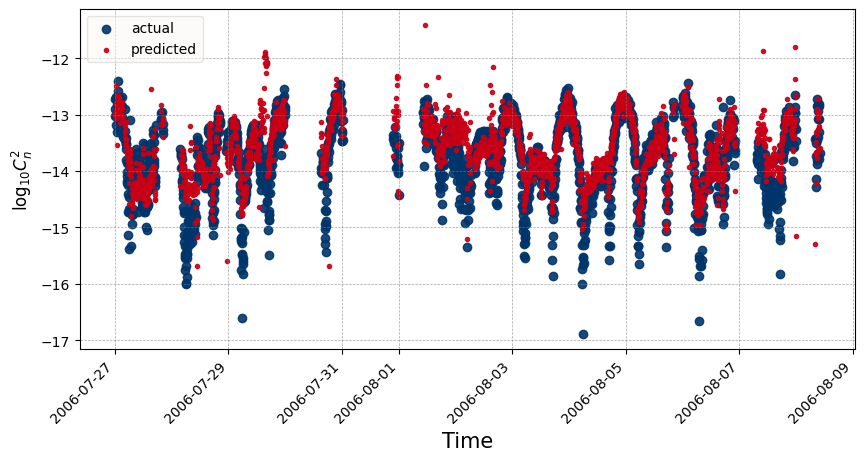

In [15]:
fig, ax = plot_predictions(y_test, y_pred)